In [2]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 

using Images
using PyPlot
using JLD

include("Common.jl")









Common

In [3]:
#---------------------------------------------------------
# Conditioning: Normalization of coordinates for numeric stability.
#
# INPUTS:
#   points    unnormalized coordinates
#
# OUTPUTS:
#   U         normalized (conditioned) coordinates
#   T         [3x3] transformation matrix that is used for
#                   conditioning
#
#---------------------------------------------------------
function condition(points::Array{Float64,2})
  # just insert your problem2 condition method here..
  
    Tx=mean(points[:,1])
    Ty=mean(points[:,2])
    S=0.5*maximum(sqrt(abs2(points[:,1])+abs2(points[:,2])))   # transformation matrix values for  set of points
    T=[1/S 0 -Tx/S ; 0 1/S -Ty/S; 0 0 1]    # transformation matrices
    U=T*points #trasnformed  points
    
  @assert size(U) == size(points)
  @assert size(T) == (3,3)
  return U::Array{Float64,2},T::Array{Float64,2}
end


condition (generic function with 1 method)

In [4]:

#---------------------------------------------------------
# Enforce a rank of 2 to a given 3x3 matrix.
#
# INPUTS:
#   A     [3x3] matrix (of rank 3)
#
# OUTPUTS:
#   Ahat  [3x3] matrix of rank 2
#
#---------------------------------------------------------
# Enforce that the given matrix has rank 2
function enforcerank2(A::Array{Float64,2})

    U_F, D_F, V_F =svd(A, thin=false)   # finding the SVD of here obtained fundamental matrix   
    D_F[end]=0    # forcing the smallest eigen value to be zero
    Ahat=U_F*diagm(D_F)*V_F'   # recreating the F matrix

  @assert size(Ahat) == (3,3)
  return Ahat::Array{Float64,2}
end


enforcerank2 (generic function with 1 method)

In [5]:

#---------------------------------------------------------
# Compute fundamental matrix from conditioned coordinates.
#
# INPUTS:
#   p1     set of conditioned coordinates in left image
#   p2     set of conditioned coordinates in right image
#
# OUTPUTS:
#   F      estimated [3x3] fundamental matrix
#
#---------------------------------------------------------
# Compute the fundamental matrix for given conditioned points
function computefundamental(p1::Array{Float64,2},p2::Array{Float64,2})
  
    data = zeros(8,9)   #using 8*9 matrix for 8 points 9 entries per row
    for i = 1:8
    M = p1[:,i]*(p2[:,i]')
    data[i,:] = M[:]
    end
    
    U,D,V = svd(data,thin=false)  # calculating SVD to find Fundamental matrix    #says to use thin false
        
    F1 = reshape(V[:,end],3,3)'    # converting the result into 3*3 matrix to form Fundamental matrix
    F = enforcerank2(F1)
  @assert size(F) == (3,3)
  return F::Array{Float64,2}
end


computefundamental (generic function with 1 method)

In [6]:

#---------------------------------------------------------
# Compute fundamental matrix from unconditioned coordinates.
#
# INPUTS:
#   p1     set of unconditioned coordinates in left image
#   p2     set of unconditioned coordinates in right image
#
# OUTPUTS:
#   F      estimated [3x3] fundamental matrix
#
#---------------------------------------------------------
function eightpoint(p1::Array{Float64,2},p2::Array{Float64,2})
    
    Tpoints1,T = condition(p1)
    Tpoints2,Tp = condition(p2)
    
    F_mat = computefundamental(Tpoints1,Tpoints2)  
    F = Tp'*F_mat*T
  @assert size(F) == (3,3)
  return F::Array{Float64,2}
end




eightpoint (generic function with 1 method)

In [7]:

#---------------------------------------------------------
# Draw epipolar lines:
#   E.g. for a given fundamental matrix and points in first image,
#   draw corresponding epipolar lines in second image.
#
#
# INPUTS:
#   Either:
#     F         [3x3] fundamental matrix
#     points    set of coordinates in left image
#     img       right image to be drawn on
#
#   Or:
#     F         [3x3] transposed fundamental matrix
#     points    set of coordinates in right image
#     img       left image to be drawn on
#
#---------------------------------------------------------
function showepipolar(F::Array{Float64,2},points::Array{Float64,2},img::Array{Float64,3})
   
    imshow(img,interpolation="none")
    n=size(points,1)
    
    points=Common.cart2hom(points')
    line1=zeros(3,n)
    
    for i=1:n
    	line1[:,i] = F*points[:,i]  # f already transposed
    end
    
    
    for i=1:n
      x=0:640
      y=-(line1[1,i]*x+line1[3,i])/line1[2,i]
      plot(x,y, color="red",linewidth="0.5")
    end

     
    ax = gca()
      # limiting x and y to remain within picture dimensions
    ax[:set_ylim]([size(img,1),0])
    ax[:set_xlim]([0,size(img,2)])
  
  return nothing::Void
end


showepipolar (generic function with 1 method)

In [8]:

#---------------------------------------------------------
# Compute the residual errors for a given fundamental matrix F,
# and set of corresponding points.
#
# INPUTS:
#    p1    corresponding points in left image
#    p2    corresponding points in right image
#    F     [3x3] fundamental matrix
#
# OUTPUTS:
#   residuals      residual errors for given fundamental matrix
#
#---------------------------------------------------------
function computeresidual(p1::Array{Float64,2},p2::Array{Float64,2},F::Array{Float64,2})
  n=size(p1,2)
    display(n)
  residual=zeros(Float64,(1,n)) # create an 1*16 residual array
    
  for i = 1:n
  residual[:,i] = (p1[:,i]'*F*p2[:,i])
  end
  return residual::Array{Float64,2}
end


computeresidual (generic function with 1 method)

16

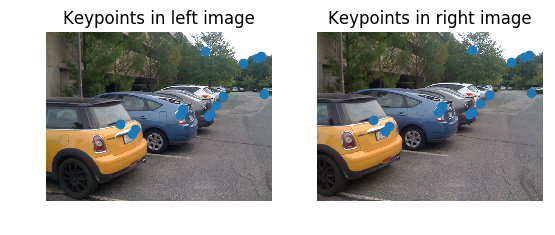

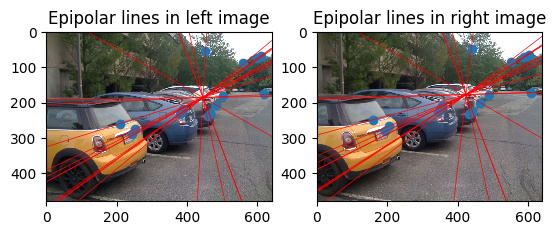

Residuals:
[-0.0174936 0.00428328 -0.0694969 -0.0174936 0.00779614 0.0165901 0.0190899 -0.0124424 -0.0153723 -0.0249157 -0.0124424 -0.00212302 0.0164549 -0.080643 0.0164183 -0.0727961]
Epipole 1: [445.435, 185.385]
Epipole 2: [424.018, 176.907]


In [10]:

#---------------------------------------------------------
# Problem 3: Fundamental Matrix
#---------------------------------------------------------

  # Load images and points
  img1 = Float64.(PyPlot.imread("a3p3a.png"))
  img2 = Float64.(PyPlot.imread("a3p3b.png"))
  points1 = load("points.jld", "points1")
  points2 = load("points.jld", "points2")
    
    

  # Display images and correspondences
  figure()
  subplot(121)
  imshow(img1,interpolation="none")
  axis("off")
  scatter(points1[:,1],points1[:,2])
  title("Keypoints in left image")
  subplot(122)
  imshow(img2,interpolation="none")
  axis("off")
  scatter(points2[:,1],points2[:,2])
  title("Keypoints in right image")

  # compute fundamental matrix with homogeneous coordinates
  x1 = Common.cart2hom(points1')

  x2 = Common.cart2hom(points2')
   
  F = eightpoint(x1,x2)
     
    
    
   
  # draw epipolar lines
  figure()
  subplot(121)
  showepipolar(F',points2,img1)
  scatter(points1[:,1],points1[:,2])
  title("Epipolar lines in left image")
  subplot(122)
  showepipolar(F,points1,img2)
  scatter(points2[:,1],points2[:,2])
  title("Epipolar lines in right image")

  # check epipolar constraint by computing the remaining residuals
  residual = computeresidual(x1, x2, F)
  println("Residuals:")
  println(residual)

  # compute epipoles
  U,_,V = svd(F)
  e1 = V[1:2,3]./V[3,3]
  println("Epipole 1: $(e1)")
  e2 = U[1:2,3]./U[3,3]
  println("Epipole 2: $(e2)")
